<a href="https://colab.research.google.com/github/Meet-Patel2580/Reinforcement_Learning/blob/main/Neural_Network_GridEnv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import agent and network and other needed packages
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/CoOp Project')
#from pyfiles.DeepQ import DQ_agent
from pyfiles.DeepQ import DeepQNetwork as DQN
from pyfiles.M_env import MeetEnv
import torch as T
import torch.nn as nn # to handle layers
import torch.nn.functional as F # for activation function
import torch.optim as optim # for optimizer

#import env


Mounted at /content/drive


In [2]:
class DQ_agent(object): # from youtube tutorial https://www.youtube.com/watch?v=wc-FxNENg9U
    def __init__(self, gamma, epsilon, lr, input_dims,fc1_dims, fc2_dims ,batch_size, n_actions, env,
                 max_mem_size=100000, eps_end=0.01, eps_decay=0.01, replace_counter=300, state_rep="none"):
        self.replace_counter=replace_counter
        self.steps = 0
        self.learn_step_counter=0
        ######################
        self.gamma   = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_decay
        self.lr      = lr
        self.action_space = [i for i in range(n_actions)]
        self.nstates=env.nstates
        self.shape=env.shape
        self.fc1_dims=fc1_dims
        self.fc2_dims=fc2_dims
        
        self.mem_size     = max_mem_size
        self.batch_size   = batch_size
        self.mem_cntr     = 0

        self.Q_eval = DQN(input_dims,n_actions=n_actions,fc1_dims=self.fc1_dims, fc2_dims=self.fc2_dims,lr=self.lr)
        self.Q_target = DQN(input_dims,n_actions=n_actions,fc1_dims=self.fc1_dims, fc2_dims=self.fc2_dims,lr=self.lr)
        
        #memory buffers
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory    = np.zeros(self.mem_size, dtype=np.float32)
        self.reward_memory    = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory  = np.zeros(self.mem_size, dtype=np.bool)  # value of terminal state is always 0 so there are no future rewards to attain

        if state_rep == "none":
          self.state_representation = self.no_representation
        elif state_rep == "one hot":
          self.state_representation=self.one_hot_representation
        elif state_rep == "coordinate":
          self.state_representation= self.coordinate_representation
          
    def linear_epsilon_decay(self):
       if self.epsilon > self.eps_min:
        self.epsilon -= self.eps_dec
       else:
        self.epsilon = self.eps_min

    def sigmoidal_epsilon_decay(self, step):
      x_stretch= 0.1
      x_translate= 100
      if self.epsilon>self.eps_min:
        self.epsilon= 1.0 / (1.0 + np.exp(x_stretch*(step-x_translate)))
      else:
        self.epsilon=self.eps_min


    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_cntr % self.mem_size # wrap around and rewrite earliest memories after memory is full
        self.state_memory[index]     = state
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.new_state_memory[index] = next_state
        self.terminal_memory[index]  = done

        self.mem_cntr += 1

    def choose_action(self,observation):
      # epsilon greedy action selection 
        if np.random.random() > self.epsilon:
            # take best action
            vector=self.state_representation(observation)
            state = T.Tensor([vector]).to(self.Q_eval.device)  # need square brackets bc this makes it a batch of size 1
            actions = self.Q_eval(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        self.steps+=1
        return action

    def coordinate_representation(self, observation): 
      coordinate_row = int(observation/self.shape[1])
      coordinate_col = observation%self.shape[1]
      coordinate = np.zeros(2)
      coordinate[0]= coordinate_row
      coordinate[1]=coordinate_col
      return coordinate

    def one_hot_representation(self, observation):
      vector= np.zeros(self.nstates)
      vector[observation]=1
      return vector

    def no_representation(self, observation):
      return observation

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return # don't bother learning if you don't have enough examples
        else:
            if self.replace_counter is not None and self.learn_step_counter%self.replace_counter==0:
              self.Q_target.load_state_dict(self.Q_eval.state_dict())

            self.Q_eval.optimizer.zero_grad()
            max_mem = min(self.mem_size, self.mem_cntr)
            batch   = np.random.choice(max_mem, self.batch_size, replace=False) #sample without replacement

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            state_batch     = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
            new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
            reward_batch    = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
            terminal_batch  = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
            action_batch    = self.action_memory[batch] #doesn't need to be torch tensor

            q_eval = self.Q_eval(state_batch)[batch_index, action_batch]
            q_next = self.Q_target(new_state_batch) # don't need to get specific actions here, going to get max actions after
            q_next[terminal_batch] = 0.0

            q_target = reward_batch + self.gamma* T.max(q_next, dim=1)[0] # along action dimension, 0th dim since max returns value, index so we just want value

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward() # backprop the error 
            self.Q_eval.optimizer.step() #weight update

        

In [3]:
env = MeetEnv((5,5),4)
agent = DQ_agent(gamma=0.99, epsilon=1,batch_size=64, n_actions=4, env=env,
                  eps_end=0.0001, input_dims=[2], lr=0.0005, fc1_dims=100, fc2_dims=50, state_rep="coordinate")
scores, eps_history = [], []
n_games = 4000

for i in range(n_games):
    score = 0
    done  = False
    observation = np.random.choice(env.nstates)
    max_steps=300
    for steps in range(max_steps):
        action = agent.choose_action(observation)
        observation_, reward, done = env.move(observation, action)
        score += reward
        agent.store_transition(observation, action,reward,observation_,done)
        agent.learn()
        observation = observation_
        steps+=1
        if done:
          break
    agent.sigmoidal_epsilon_decay(i)
    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])
    print(f'episode:{i}, score: {score}, avg:{ avg_score}, epsilon: {agent.epsilon}')

episode:0, score: 9.0, avg:9.0, epsilon: 0.9999546021312976
episode:1, score: 100.0, avg:54.5, epsilon: 0.9999498278353162
episode:2, score: 99.0, avg:69.33333333333333, epsilon: 0.9999445514752772
episode:3, score: 80.0, avg:72.0, epsilon: 0.9999387202603833
episode:4, score: 86.0, avg:74.8, epsilon: 0.9999322758503804
episode:5, score: 100.0, avg:79.0, epsilon: 0.9999251537724895
episode:6, score: 92.0, avg:80.85714285714286, epsilon: 0.9999172827771484
episode:7, score: 88.0, avg:81.75, epsilon: 0.9999085841261478
episode:8, score: 79.0, avg:81.44444444444444, epsilon: 0.9998989708060922
episode:9, score: 99.0, avg:83.2, epsilon: 0.9998883466593704
episode:10, score: 96.0, avg:84.36363636363636, epsilon: 0.9998766054240137
episode:11, score: 98.0, avg:85.5, epsilon: 0.9998636296729204
episode:12, score: 83.0, avg:85.3076923076923, epsilon: 0.9998492896419403
episode:13, score: 99.0, avg:86.28571428571429, epsilon: 0.9998334419352227
episode:14, score: 45.0, avg:83.53333333333333, ep

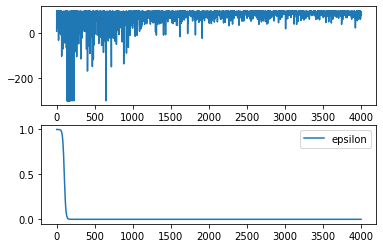

In [4]:
# plot learning
x = [i+1 for i in range(n_games)]
fig, ax = plt.subplots(2,1)
ax[0].plot(x, scores, label='score')
ax[1].plot(x,eps_history,label='epsilon')
plt.legend(loc=0)
plt.show()

In [ ]:
results_dictionary={}
results_dictionary[(100,50)] = scores

In [ ]:
network = DQN([2], 100, 50, 4, 0.001 ) #set variables outside of instantiation
state = (3,3)
state_tensor= T.Tensor([state])
action = network(state_tensor)
#print(action)

tensor([[-0.0958,  0.0565, -0.5433,  0.3389]], grad_fn=<AddmmBackward>)


In [ ]:
def convert_to_coordinate(state, env):  
  coordinate_row = int(state/env.shape[1])
  coordinate_col = state%env.shape[1]
  coordinate = (coordinate_row,coordinate_col)
  return coordinate